In [74]:
%pylab inline

import numpy as np
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Face recognition

The goal of this seminar is to build two simple (anv very similar) face recognition pipelines using **`scikit-learn`** package. Overall, we'd like to explore different representations and see which one works better. 

## Prepare dataset

In [75]:
import scipy.io

image_h, image_w = 32, 32

data = scipy.io.loadmat('faces_data.mat')

X_train = data['train_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_train = (data['train_labels'] - 1).ravel()
X_test = data['test_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_test = (data['test_labels'] - 1).ravel()

n_features = X_train.shape[1]
n_train = len(y_train)
n_test = len(y_test)
n_classes = len(np.unique(y_train))

print('Dataset loaded.')
print('  Image size        : {}x{}'.format(image_h, image_w))
print('  Train images      : {}'.format(n_train))
print('  Test images       : {}'.format(n_test))
print('  Number of classes : {}'.format(n_classes))

Dataset loaded.
  Image size        : 32x32
  Train images      : 280
  Test images       : 120
  Number of classes : 40


Now we are going to plot some samples from the dataset using the provided helper function.

In [76]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, interpolation='nearest')
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

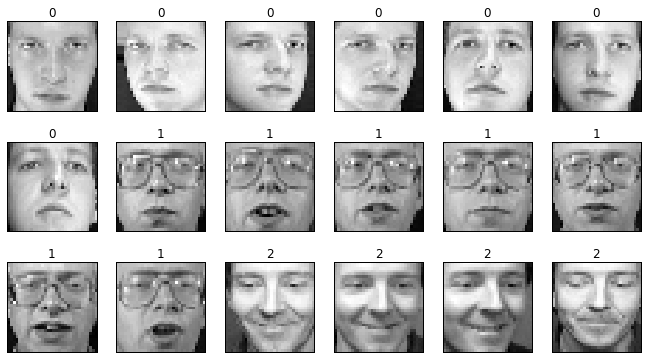

In [77]:
titles = [str(y) for y in y_train]

plot_gallery(X_train, titles, image_h, image_w)

## Nearest Neighbour baseline

The simplest way to do face recognition is to treat raw pixels as features and perform **Nearest Neighbor Search** in the Euclidean space. Let's use **`KNeighborsClassifier`** class.

In [78]:
from sklearn.neighbors import KNeighborsClassifier

nc = KNeighborsClassifier(n_neighbors = 3)
nc.fit(X_train, y_train)
test_score = nc.score(X_test, y_test)

print('Test score: {}'.format(test_score))

Test score: 0.8416666666666667


Not very imperssive, is it?

## Eigenfaces

All the dirty work will be done by the scikit-learn package. First we need to learn a dictionary of codewords. For that we preprocess the training set by making each face normalized (zero mean and unit variance)..

In [79]:
# Populate variable 'X_train_processed' with samples each of which has zero mean and unit variance.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train.astype(float))
X_test_processed = scaler.transform(X_test.astype(float))

Now we are going to apply **PCA** to obtain a dictionary of codewords. 
**`RamdomizedPCA`** class is what we need.

In [80]:
from sklearn.decomposition import RandomizedPCA

def apply_pca(train, test, nc):
    pca = RandomizedPCA(n_components = nc)
    pca.fit(train)
    train_pca = pca.transform(train)
    test_pca = pca.transform(test)
    return train_pca, test_pca, pca

X_train_pca, X_test_pca, pca = apply_pca(X_train_processed, X_test_processed, 64)

We plot a bunch of principal components.

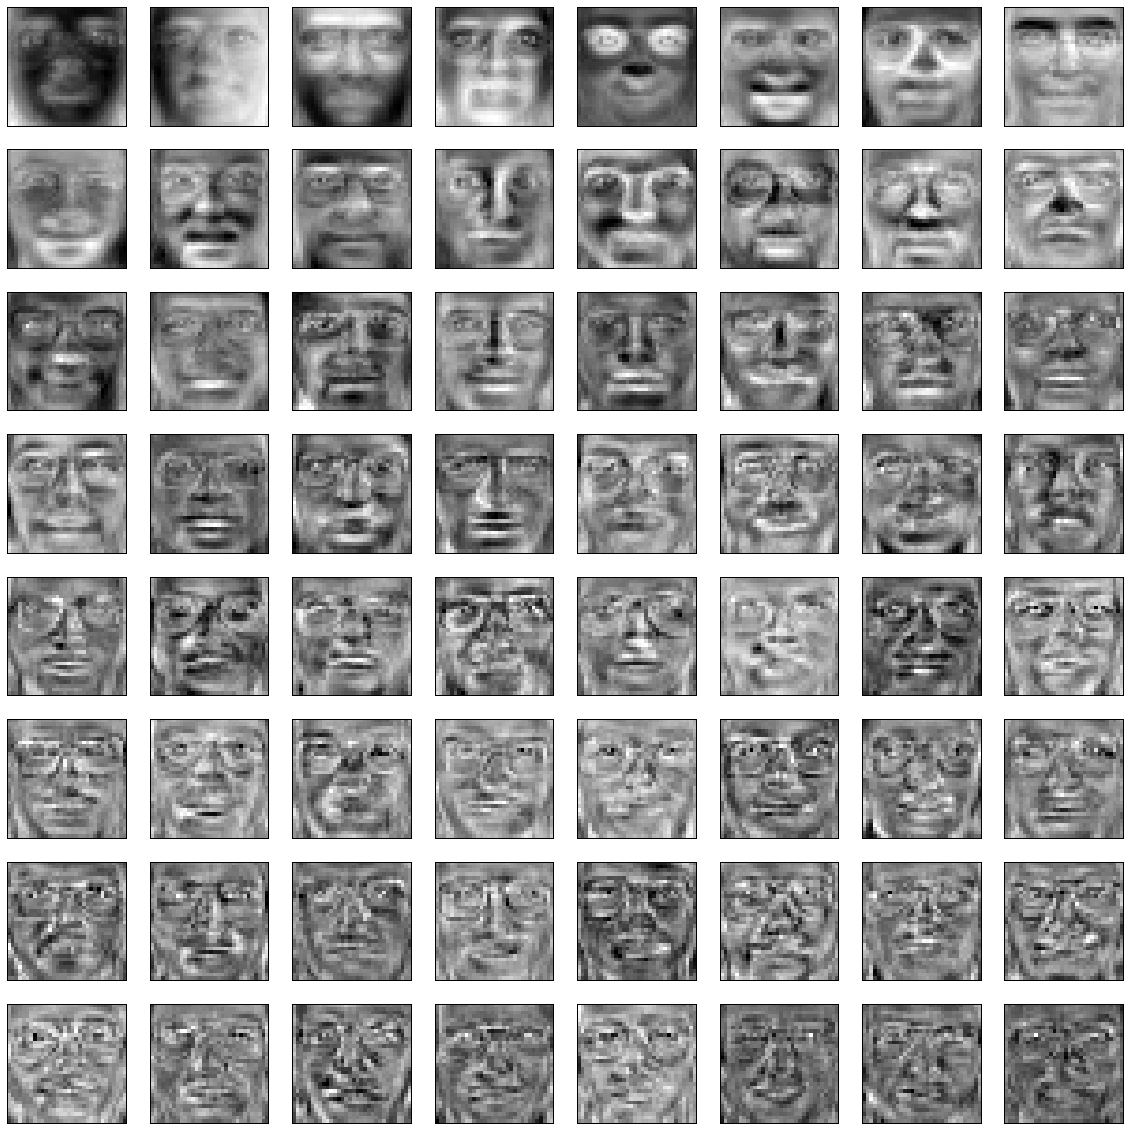

In [81]:
# Visualize principal components.
plt.figure(figsize=(20,20))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(pca.components_[i].reshape(32, 32), cmap=plt.cm.gray, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())

Transform training data, train an SVM and apply it to the encoded test data.

In [82]:
from sklearn.svm import SVC

def calc_svc_score(train_x, train_y, test_x, test_y):
    svc = SVC(kernel = 'linear')
    svc.fit(train_x, train_y)
    return svc.score(test_x, test_y)

print('Test score: {}'.format(calc_svc_score(X_train_pca, y_train, X_test_pca, y_test)))

Test score: 0.95


How many components are sufficient to reach the same accuracy level?

Max accuracy: 0.95


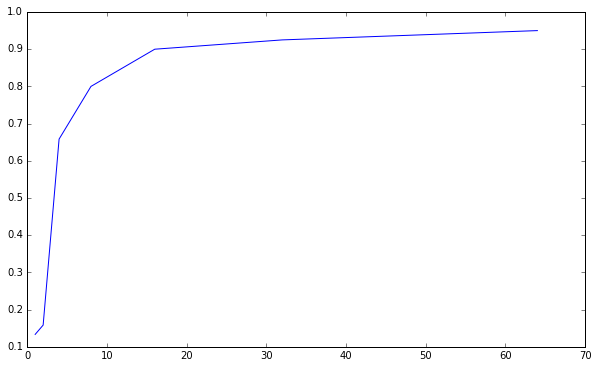

In [83]:
n_components = [1, 2, 4, 8, 16, 32, 64]
accuracy = []

for nc in n_components:
    X_train_pca, X_test_pca, pca = apply_pca(X_train_processed, X_test_processed, nc)
    accuracy.append(calc_svc_score(X_train_pca, y_train, X_test_pca, y_test))
    
plt.figure(figsize=(10, 6))
plt.plot(n_components, accuracy)

print('Max accuracy: {}'.format(max(accuracy)))